 # Estimating an Environmental Kuznets Relationship Using Mallow's Cj

### Ayan Sarkar 
### May 9, 2023 
### Econ 143 Spring '24

In [67]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn import tree
from sklearn.linear_model import LinearRegression

from scipy.interpolate import griddata

## Project Description

The existence of the Environmental Kuznets Curve (EKC) in empirircal analysis is a source of debate. There is also substantial epirical evidence to suggest there is an eventual reduction in emissions associated with higher per capital income levels, which may be attributable to the ‘abatement effect’ that arises as countries become richer (Panayotou 1997). In this project, I attempt to replicate/observe a non-linear relationship between NOX emmission levels for countries that belong to The Organization for Economic Cooperation and Development (OECD) and their respective Gross National Incomes, based on the concept of the EKC by using Mallows Cj to estmate optimal model complexity by minimzing risk. I intitally chose to study OECD Countries because of ease and accesseibility of data access, and because the organization develops policy standards for sustainable trade and growth.

Mallow’s Cj is a metric for evaluating statistical models by assessing the bias or prediction inaccuracy introduced in predictions due to the absence of crucial features. I hope to demonstrate an inverted U-shape Kuznets relationship, as developed in literature for certain pollutants by Grossman & Kreuger 1995 by utilizing this model selection algorithm. 

I merged OECD data on country-level air pollutant emmissions data along with Gross National Income (GNI) Data sourced from a UN Human Development Report (UNHDP). Utilising a sample of all 30+ OECD Countries, I regress GNI per capita on OECD Nitrogen Oxide Total emmissions data in kilogram per capita. I use Mallows' Cj to  feasibly estimate variance, which allows me to choose J, the number of basis functions in the approximation. I additionally include a base-case estimation of the Kuznets relation using standard OLS, and I observe a roughly similar quadratic relationship between the two estimation methods.

![Environmental Kuznets Curve](Environmental-Kuznets-Curve.ppm)


## Clean & Prepare Data for Analysis

In [68]:
#Read in data and clean
oecd_nox = pd.read_csv('oecd_modified.csv', header = 0)
oecd_nox['Constant'] = 1
oecd_nox = oecd_nox.dropna(subset=['Gross_National_Income_per_capita'])
oecd_nox['GNI_pc'] = np.log(oecd_nox['Gross_National_Income_per_capita'])
oecd_nox['Pollution_pc'] = np.log(oecd_nox['Value'])
oecd_nox = oecd_nox[oecd_nox['Year'] == 2000]
oecd_nox.reset_index(drop=True, inplace=True)
oecd_nox.drop(columns=['Population.y'], inplace=True)  # Drop the column 'Pollution.y'
oecd_nox.rename(columns={'Population.x': 'Population'}, inplace=True) 
oecd_nox[['Constant', 'GNI_pc', 'Pollution_pc']].head()

,Constant,GNI_pc,Pollution_pc
0,1,10.526659,7.539685
1,1,10.758569,5.350184
2,1,10.718511,5.870903
3,1,10.576121,7.903204
4,1,9.397860,3.710983


## Summary Statistics

In [69]:
# Calculate descriptive statistics for each variable
statistics = {
    'Variable': ['GNI_pc', 'Population', 'Pollution_pc'],
    'Mean': [round(oecd_nox['GNI_pc'].mean(), 4), 
             round(oecd_nox['Population'].mean(), 4), 
             round(oecd_nox['Pollution_pc'].mean(), 4)],
    'Maximum': [round(oecd_nox['GNI_pc'].max(), 4), 
                round(oecd_nox['Population'].max(), 4), 
                round(oecd_nox['Pollution_pc'].max(), 4)],
    'Minimum': [round(oecd_nox['GNI_pc'].min(), 4), 
                round(oecd_nox['Population'].min(), 4), 
                round(oecd_nox['Pollution_pc'].min(), 4)],
    'Std.Dev.': [round(oecd_nox['GNI_pc'].std(), 4), 
                 round(oecd_nox['Population'].std(), 4), 
                 round(oecd_nox['Pollution_pc'].std(), 4)],
    'Skewness': [round(oecd_nox['GNI_pc'].skew(), 4), 
                 round(oecd_nox['Population'].skew(), 4), 
                 round(oecd_nox['Pollution_pc'].skew(), 4)],
    'Kurtosis': [round(oecd_nox['GNI_pc'].kurtosis(), 4), 
                 round(oecd_nox['Population'].kurtosis(), 4), 
                 round(oecd_nox['Pollution_pc'].kurtosis(), 4)]
}

# Create DataFrame from dictionary
statistics_df = pd.DataFrame(statistics)

# Print the table
display(statistics_df.style.hide_index())


/var/folders/9t/zsl748y93k95tp4c5122vtxw0000gn/T/ipykernel_6073/604954494.py:28: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(statistics_df.style.hide_index())


Variable,Mean,Maximum,Minimum,Std.Dev.,Skewness,Kurtosis
GNI_pc,10.396100,11.271600,9.397900,0.482800,-0.751600,-0.047700
Population,28961848.031200,279040168.000000,279049.000000,53804802.015700,3.649200,15.466700
Pollution_pc,5.797100,9.916500,3.422500,1.548300,0.495700,0.014800


## OLS Regression Fit

Coefficients: 
 [-5.7895927   1.11452091]


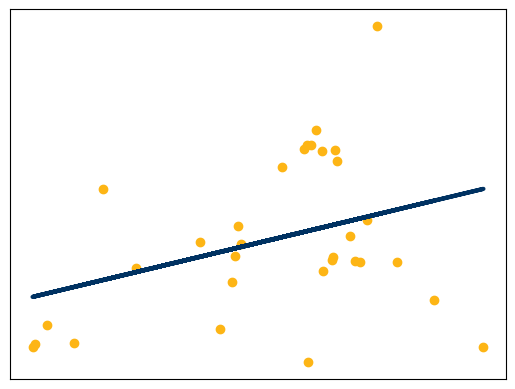

In [70]:
#Fit a linear Model of GNI per capita on total man-made NOx emmission and plot
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Selecting independent variables (features)
W = oecd_nox[['Constant', "GNI_pc"]]

# Selecting dependent variable (target)
Y = oecd_nox['Pollution_pc']

# Create linear regression object
regr = LinearRegression(fit_intercept=False)

# Fit the calorie demand model
regr.fit(W, Y)

# Compute fitted values
kuznets_pred = regr.predict(W)

# Print out the estimated regression coefficients
print("Coefficients: \n", regr.coef_)

# Plot fitted regression model
plt.scatter(oecd_nox['GNI_pc'], oecd_nox['Pollution_pc'], 
            color="#FDB515")
plt.plot(oecd_nox['GNI_pc'], kuznets_pred, 
         color="#003262", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Estimate Mallow's Cj

### Mallow's Cj Criterion:

$$
C_{j} = -{N}\widetilde{\sigma}^2 + 2\sum_{i=1}^{N} (Y_i - \hat{m}_{J} (x_i))^2 + 2\sigma^2\tilde{\mathbf{J}}
$$

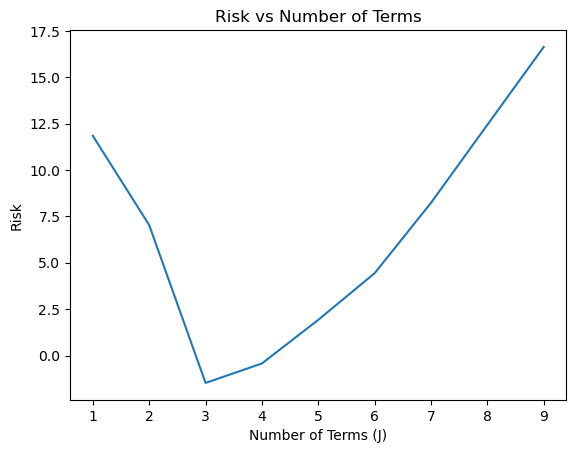

In [71]:
# Set Gross National Income per capita as X & Pollution per capita as Y
X = oecd_nox['GNI_pc']
Y = oecd_nox['Pollution_pc']

# Write function that computes the series regression of Y 
# onto 1, X, X2, ..., XJ-1 by least squares
def series(Y, X, J):
    N = len(Y)
    W = {}
    for j in range(J):
        # Create a dictionary with keys W0, W1, W2, ..., WJ-1
        W['W' + str(j)] = X ** j  
    W = pd.DataFrame(W)  # Convert the dictionary to a DataFrame
    
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(W, Y)
    m_hat = regr.predict(W)
    SSR = np.sum((Y - m_hat) ** 2)
    s2 = (1 / (N - J)) * SSR
    return [SSR, s2]

# Write a Mallows function
def mallowsCj(Y, X, L):
    N = len(Y)
     # changed to L-1 
    risk_table = np.zeros((L-1, 2)) 
    [_, s2_L] = series(Y, X, L)  # big model for J in range (1,L):
    for J in range(1, L):
        [SSR_J, _] = series(Y, X, J)
        Cj = -N * s2_L + SSR_J + 2 * s2_L * J
        risk_table[J-1, :] = [J, Cj]
    return risk_table

# Plot risk based on new risk table using Mallows with J & L specified
J = 5
L = 10
risk_table = mallowsCj(Y, X, L)
plt.plot(risk_table[:, 0], risk_table[:, 1])
plt.xlabel('Number of Terms (J)')
plt.ylabel('Risk')
plt.title('Risk vs Number of Terms')
plt.show()


## Fit the Model According to Mallow's Risk Minimizing Specification

In [72]:
# Calculate additional columns for powers of log_gni based off of risk table
oecd_nox['GNI_pc^2'] = oecd_nox['GNI_pc'] ** 2
oecd_nox['GNI_pc^3'] = oecd_nox['GNI_pc'] ** 3


# Now W includes the constant and powers of log_gni up to the 3rd power
W = oecd_nox[['Constant', 'GNI_pc', 'GNI_pc^2', 'GNI_pc^3']]

Y = oecd_nox['Pollution_pc']  

# Create linear regression object with no intercept 
# since 'constant' column is used
regr = linear_model.LinearRegression(fit_intercept=False)

# Fit the model
regr.fit(W, Y).get_params()

# Compute fitted values
value_pred = regr.predict(W)

# Print out the estimated regression coefficients
print("Regression Coefficients: \n", regr.coef_)


Regression Coefficients: 
 [2413.71515238 -729.27501791   73.31740274   -2.44738006]


## Output Mallow's Regression Results

In [73]:
import statsmodels.api as sm

# Add a constant term to the independent variables
W = sm.add_constant(W)

# Fit the linear regression model
model = sm.OLS(Y, W)
results = model.fit()

# Print the regression table
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           Pollution_pc   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     4.665
Date:                Thu, 09 May 2024   Prob (F-statistic):            0.00913
Time:                        12:08:27   Log-Likelihood:                -52.401
No. Observations:                  32   AIC:                             112.8
Df Residuals:                      28   BIC:                             118.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant    2413.7152   2020.309      1.195      0.2

## Visualize Mallow's Unbiased Risk Estimate Fit

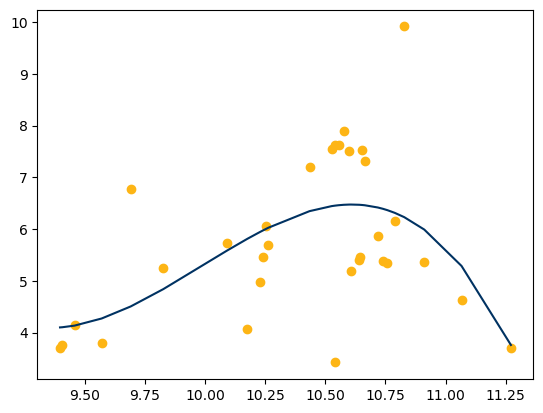

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Generate scatter plot
plt.scatter(oecd_nox['GNI_pc'], oecd_nox['Pollution_pc'], color="#FDB515")

# For plotting the fitted model, sort the values since the line needs to be continuous
sorted_order = np.argsort(oecd_nox['GNI_pc'])
plt.plot(oecd_nox['GNI_pc'].iloc[sorted_order], value_pred[sorted_order], color="#003262")

plt.show()


From the plot above, we can observe how the line of fit now incorporates the optimal number of features as prescribed by the risk table. The scatter plot of the data is shown with a model fit with J=3, resulting in a non-linear best fit. This result is interesting, because by utilizing a model selection algorithm, I am able to roughly observe a non-linear fit between Income and Pollution as hypothesized in the literature.

## Estimate Standard OLS Model

In [75]:
# Assuming 'oecd_nox' is your DataFrame containing the data
oecd_nox['GNI_pc^2'] = oecd_nox['GNI_pc'] ** 2

# Add constant term and squared term of 'GNI_pc' to the independent variables
X = sm.add_constant(oecd_nox[['GNI_pc', 'GNI_pc^2', 'Population']])

# Fit the quadratic regression model
model = sm.OLS(oecd_nox['Pollution_pc'], X)
results = model.fit()

# Print the regression summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           Pollution_pc   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     26.18
Date:                Thu, 09 May 2024   Prob (F-statistic):           2.82e-08
Time:                        12:08:28   Log-Likelihood:                -37.504
No. Observations:                  32   AIC:                             83.01
Df Residuals:                      28   BIC:                             88.87
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -227.4889     60.957     -3.732      0.0

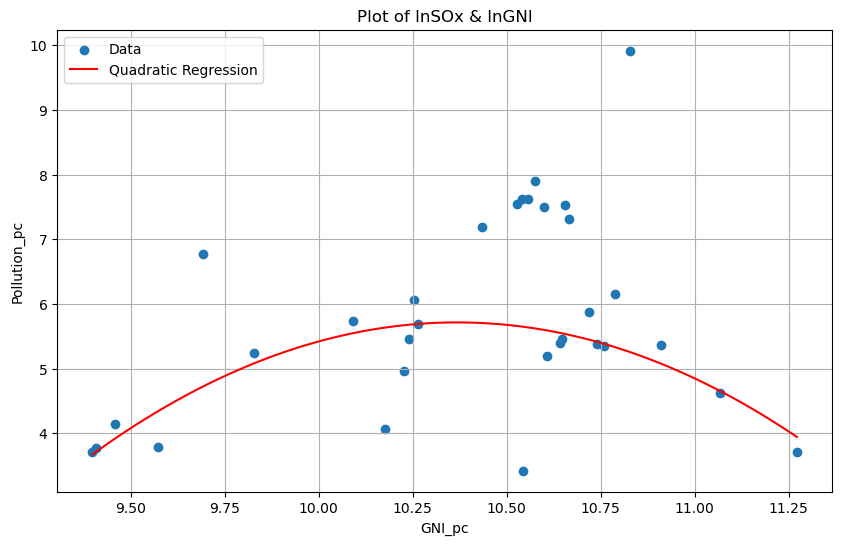

In [76]:
#Estimate an OLS Model with similar specififcations but only including a quaratic GNI term
# 'GNI_pc' is the independent variable
# 'Pollution_pc' is the dependent variable
oecd_nox['GNI_pc^2'] = oecd_nox['GNI_pc'] ** 2

# Add constant term and squared term of 'GNI_pc' to the independent variables
X = sm.add_constant(oecd_nox[['GNI_pc', 'GNI_pc^2', 'Population']])

# Fit the quadratic regression model
model = sm.OLS(oecd_nox['Pollution_pc'], X)
results = model.fit()

# Generate predicted values for 'GNI_pc' range
gnipc_range = np.linspace(oecd_nox['GNI_pc'].min(), oecd_nox['GNI_pc'].max(), 100)
gnipc_range_squared = gnipc_range ** 2
X_pred = sm.add_constant(np.column_stack((gnipc_range, 
                                          gnipc_range_squared, 
                                          np.zeros_like(gnipc_range))))

# Predicted values
y_pred = results.predict(X_pred)

# Plot the data points and regression curve
plt.figure(figsize=(10, 6))
plt.scatter(oecd_nox['GNI_pc'], oecd_nox['Pollution_pc'], label='Data')
plt.plot(gnipc_range, y_pred, color='red', label='Quadratic Regression')
plt.xlabel('GNI_pc')
plt.ylabel('Pollution_pc')
plt.title('Plot of lnSOx & lnGNI')
plt.legend()
plt.grid(True)
plt.show()


I visualize the traditional Kuznets OLS fit above with a squared term, without any Mallow's specification, following the EKC literature (Sinha & Bhatt, 2017). It is easy to observe clear differences from the fit plot above.

## Visualizing NOx Emmissions & GNI in 2000 Accross OECD Countries

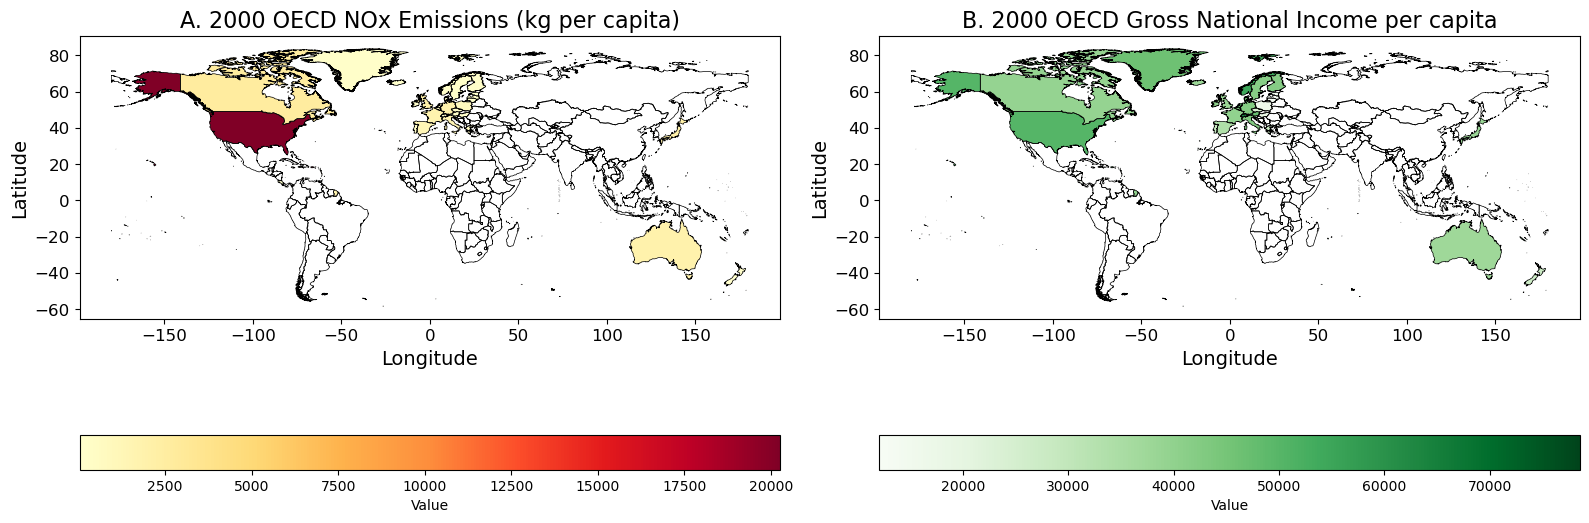

In [77]:
# Read in data and clean for clarity
oecd_nox = pd.read_csv('oecd_modified.csv', header=0)
oecd_nox = oecd_nox.dropna(subset=['Gross_National_Income_per_capita'])
oecd_nox['gni'] = oecd_nox['Gross_National_Income_per_capita']
oecd_nox['Value'] = oecd_nox['Value']
oecd_nox = oecd_nox[oecd_nox['Year'] == 2000]

# Read in the world shapefile
world_outline = gpd.read_file("world-administrative-boundaries.shp")

# Read the world shapefile for OECD countries
world_oecd = gpd.read_file("world-administrative-boundaries.shp")
world_oecd.rename(columns={"color_code": "COU"}, inplace=True)
world_oecd = pd.merge(world_oecd, oecd_nox, on="COU", how="inner")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the world map outline in the first subplot
world_outline.boundary.plot(ax=axs[0], color="black", linewidth=0.5)

# Plot the map of Gross National Income per capita for OECD countries in the first subplot
world_oecd.plot(column="Value", cmap="YlOrRd", legend=True, legend_kwds={'label': "Value", 'orientation': "horizontal"}, ax=axs[0])
axs[0].set_title("A. 2000 OECD NOx Emissions (kg per capita)", fontsize=16)
axs[0].set_xlabel("Longitude", fontsize=14)
axs[0].set_ylabel("Latitude", fontsize=14)
axs[0].tick_params(axis='both', labelsize=12)

# Plot the world map outline in the second subplot
world_outline.boundary.plot(ax=axs[1], color="black", linewidth=0.5)

# Plot the map of NOx emissions for OECD countries with green gradient
world_oecd.plot(column="gni", cmap="Greens", legend=True, legend_kwds={'label': "Value", 'orientation': "horizontal"}, ax=axs[1])
axs[1].set_title("B. 2000 OECD Gross National Income per capita", fontsize=16)
axs[1].set_xlabel("Longitude", fontsize=14)
axs[1].set_ylabel("Latitude", fontsize=14)
axs[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


## Visualizing NOx Emmissions Over Time in Large OECD Member Countries

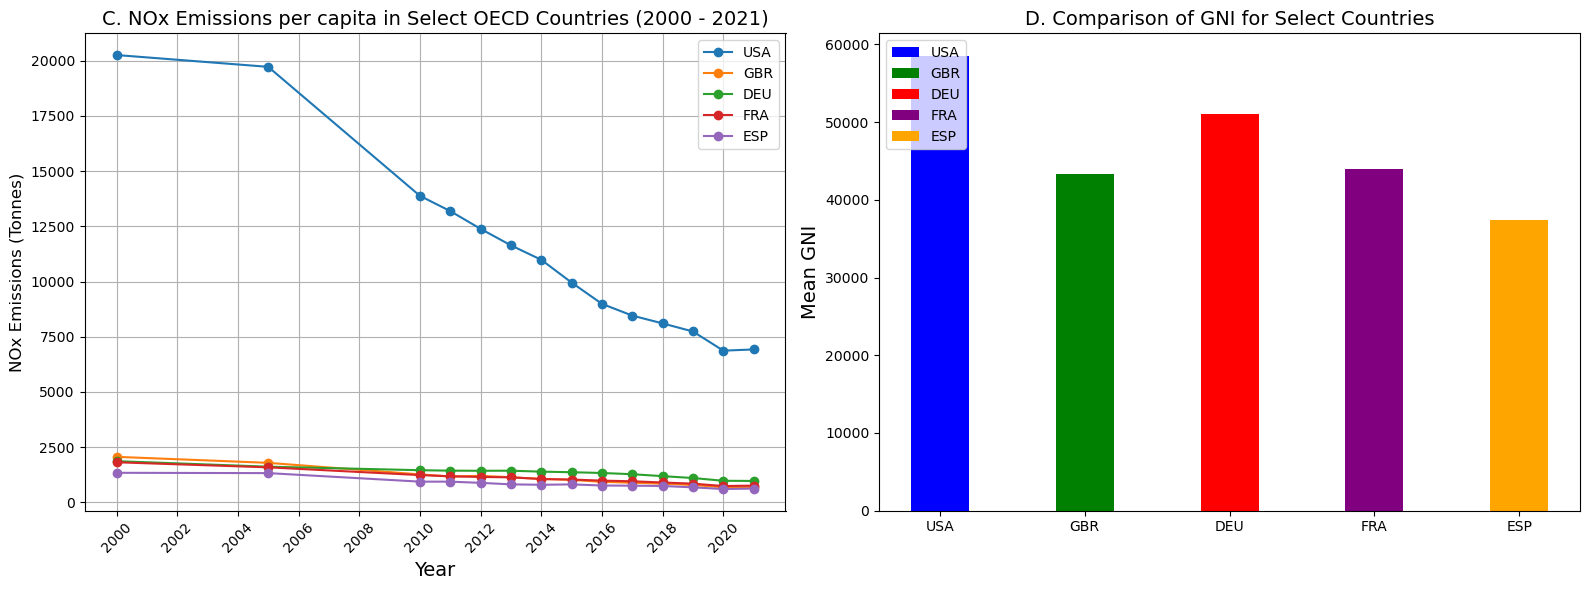

In [78]:
# Read the data
oecd_nox = pd.read_csv('oecd_modified.csv', header=0)

# List selected OECD countries
countries = ['USA', 'GBR', 'DEU', 'FRA', 'ESP']

# Set up the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for each country in the first subplot (line plot)
for country in countries:
    country_data = oecd_nox[oecd_nox['COU'] == country]
    ax1.plot(country_data['Year'], country_data['Value'], marker='o', label=country)

ax1.set_title('C. NOx Emissions per capita in Select OECD Countries (2000 - 2021)', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('NOx Emissions (Tonnes)', fontsize=12)
ax1.grid(True)
ax1.set_xticks(range(2000, 2022, 2))  # Adjust the x-axis ticks if needed
ax1.legend()
ax1.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels for better visibility and set font size
ax1.tick_params(axis='y', labelsize=10)  # Set font size for y-axis ticks

# Define colors for each country in the second subplot (bar plot)
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Filter data for select OECD countries and set up bar plot in the second subplot
selected_countries = ['USA', 'GBR', 'DEU', 'FRA', 'ESP']
selected_data = oecd_nox[oecd_nox['COU'].isin(selected_countries)]

# Plot mean GNI for each country in the second subplot (bar plot)
for i, (country, color) in enumerate(zip(selected_countries, colors)):
    country_data = selected_data[selected_data['COU'] == country]
    x = i  # x coordinate for the bars
    y_gni = country_data['Gross_National_Income_per_capita'].mean()
    ax2.bar(x, y_gni, width=0.4, label=country, color=color)

ax2.set_xticks(range(len(selected_countries)))
ax2.set_xticklabels(selected_countries)
ax2.set_ylabel('Mean GNI', fontsize=14)
ax2.set_title('D. Comparison of GNI for Select Countries', fontsize=14)
ax2.legend(loc='upper left')
ax2.tick_params(axis='x', labelsize=10)  # Set font size for x-axis ticks
ax2.tick_params(axis='y', labelsize=10)  # Set font size for y-axis ticks

# Adjust layout and display plots
plt.tight_layout()
plt.show()


Figure C shows how many of the large OECD countries show similar trends in NOx emmissions per capita, with the U.S. as a clear outlier. Since my analysis focuses on the year 2000, I found it intertesting to note the diproportinate difference in emmissions levels to GNI in the US (Figure D) to some of the other larger OECD countries.

## Potential Next Steps

My analysis does not incorporate multiple time periods, which is a clear drawback of my analysis. A panel approach would likely yield more robust results, but introduce more complexity to my estimation as I would have to consider unobserved heterogenity accross all OECD Countries over time. Ideally, I would also like to adress potential spatial effects, considering that NOx behaves like a potent local pollutant. 

It is also interesting to note that none of the coeffecients are significant using the prescibed Mallow's model complexity, while my estimates regain significance using standard OLS. I believe this may be due to multicollinearity, which is instrinsic to traditional estimation approaches used in the EKC literature. By incorporating higher order polynomials, I may in fact be introducing noise in to my predictions. This result also seems likely, since my Mallow's Prediction includes a third order polynomial in the regression.


I'd like to thank Professor Graham and Jinglin for their support this semster. Thank you!

## Works Cited

Churchill, Sefa Awaworyi, et al. "The environmental Kuznets curve in the OECD: 1870–2014." Energy economics 75 (2018): 389-399.

Grossman, Gene M., and Alan B. Krueger. “Economic Growth and the Environment.” The Quarterly Journal of Economics, vol. 110, no. 2, 1995, pp. 353–77. JSTOR, https://doi.org/10.2307/2118443. Accessed 9 May 2024.

Narayan, Paresh Kumar, and Seema Narayan. "Carbon dioxide emissions and economic growth: Panel data evidence from developing countries." Energy policy 38.1 (2010): 661-666.

Panayotou, Theodore. “Demystifying the Environmental Kuznets Curve: Turning a Black Box into a Policy Tool.” Environment and Development Economics, vol. 2, no. 4, 1997, pp. 465–84. JSTOR, http://www.jstor.org/stable/44379189. Accessed 9 May 2024.

Sinha, Apra, and M. Y. Bhatt. "Environmental Kuznets Curve for CO2and NOx emissions: A Case Study of India." European Journal of Sustainable Development 6.1 (2017): 267-267.